# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn import metrics

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import RobustScaler

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')



In [74]:
# 데이터 경로
path = "C:/Users/aryij/Documents/DataStudy/DAStudy-sat/Tek/football-data-from-transfermarkt/data/df_eda.csv"
df = pd.read_csv(path)

In [75]:
df.head()

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,0,0,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,0,0,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,7,0,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,3,0,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [76]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   yellow_cards             16001 non-null  int64  
 3   red_cards                16001 non-null  int64  
 4   goals                    16001 non-null  int64  
 5   assists                  16001 non-null  int64  
 6   minutes_played           16001 non-null  int64  
 7   competition_code         16001 non-null  object 
 8   age                      16001 non-null  int64  
 9   position                 16001 non-null  object 
 10  current_club_name        16001 non-null  object 
 11  market_value_per_season  16001 non-null  float64
 12  country                  16001 non-null  object 
 13  foot                     16001 non-null  object 
 14  height_in_cm          

In [78]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [79]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [80]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 15), (2920, 15))

In [81]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [82]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 14), (10464,), (2617, 14), (2617,), (2920, 14), (2920,))

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [83]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

# Train 데이터로 fit_transform 해준다
# train_encoded = te.fit_transform(X_train, y_train)
# val_encoded = te.transform(X_val)
# test_encoded = te.transform(X_test)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [84]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [85]:
# Baseline 모델로 선형회귀 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [86]:
# Baseline 모델 절편, 결정 계수 확인
print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  338987753.2804133
Coefficients:


[('player_name', 0.6114705210737365),
 ('start_season', -168979.61900295614),
 ('yellow_cards', 9175.741708304196),
 ('red_cards', 13960.083164684504),
 ('goals', 743863.111916122),
 ('assists', 595729.6665156991),
 ('minutes_played', 1679.1118935669117),
 ('competition_code', 0.19474274452659301),
 ('age', -270278.159960686),
 ('position', 0.057850920038617915),
 ('current_club_name', 0.37311333513935097),
 ('country', 0.02210456995635468),
 ('foot', -0.1443539909619176),
 ('height_in_cm', 20524.892072590177)]

In [87]:
# # Baseline 모델로 train 데이터셋 예측
# y_train_pred_lr = lr.predict(X_train)

# # Baseline 모델로 validation 데이터셋 예측
# y_val_pred_lr = lr.predict(X_val)

# # Baseline 모델로  test 데이터셋 예측
# y_test_pred_lr = lr.predict(X_test)

In [88]:
# # Baseline 모델의 MAE, MSE, RMSE, R2 score 확인
# base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
# base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
# base_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr))

# # metrics.r2_score(y_test, y_test_pred_lr)
# print('Baseline R squared: {:.2f}'.format(lr.score(X_test, y_test)))
# print('Baseline Mean Absolute Error:', base_meanAbErr)
# print('Baseline Mean Square Error:', base_meanSqErr)
# print('Baseline Root Mean Square Error:', base_rootMeanSqErr)

In [89]:
# # Validataion, Test 데이터셋 R2 score 비교
# print('Baseline R squared (Train): {:.2f}'.format(metrics.r2_score(y_train, y_train_pred_lr)))
# print('Baseline R squared (Validation): {:.2f}'.format(metrics.r2_score(y_val, y_val_pred_lr)))
# print('Baseline R squared (Test): {:.2f}'.format(metrics.r2_score(y_test, y_test_pred_lr)))

In [90]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = lr.predict(X_train)
    y_val_pred_lr = lr.predict(X_val)
    y_test_pred_lr = lr.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    base_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr))

    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(lr.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [91]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,5376436.65,94524126113037.91,9722351.88,0.65


## 스케일링
https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [92]:
robustScaler = RobustScaler().fit(X_train)

X_train_robust = robustScaler.transform(X_train)

X_val_robust = robustScaler.transform(X_val)

X_test_robust = robustScaler.transform(X_test)

In [93]:
# XGBoost 모델 생성
model_xgb = XGBRegressor(n_estimators=1000,
                          learning_rate=0.2,
                          min_child_weight=100,
                          max_depth=3,
                          gamma=100,
                          colsample_bytree=0.5,
                          random_state=42)

# Robust 스케일링 적용한 X_train_scaled 이용
model_xgb.fit(X_train_robust, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=100, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

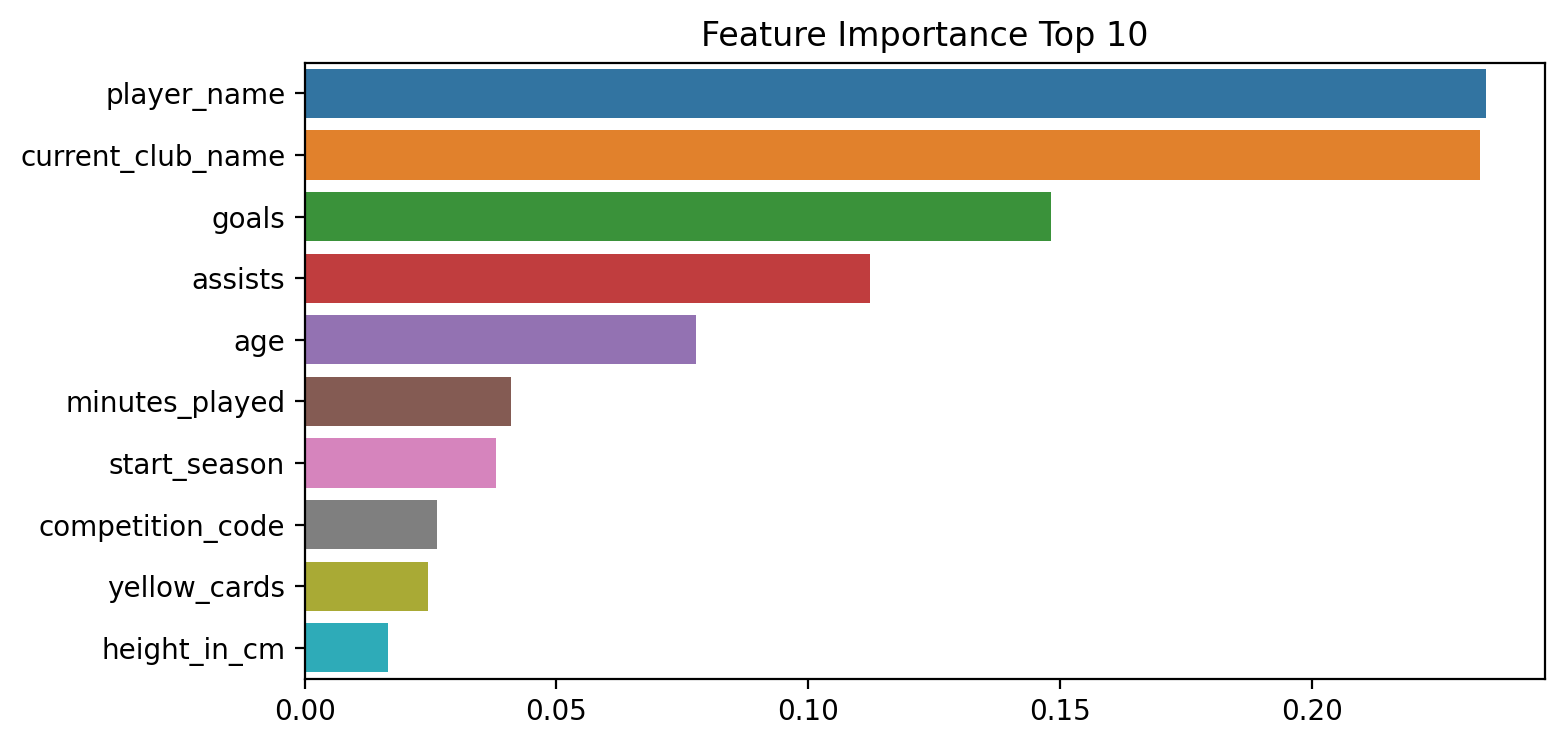

In [94]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = model_xgb.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [95]:
model_xgb.score(X_train_robust, y_train)

0.906494129819307

In [96]:
model_xgb.score(X_val_robust, y_val)

0.76636844934478

In [97]:
model_xgb.score(X_test_robust, y_test)

0.7429309592562177

In [98]:
model_xgb.predict(X_test_robust)

array([ -209802.86, 16865000.  , 18602900.  , ...,  2911008.2 ,
         888267.3 , 21360776.  ], dtype=float32)

In [99]:
# 1446
# Kai Havertz
model_xgb.predict(X_test_robust)[1446]

71119420.0

In [100]:
y_test

7          900000.0
11       30000000.0
21       28000000.0
26       15000000.0
27         500000.0
            ...    
15983     5000000.0
15988     1800000.0
15994     1000000.0
15995     1000000.0
16000    18000000.0
Name: market_value_per_season, Length: 2920, dtype: float64

In [101]:
X_test

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7,3.090621e+06,2023,1,0,0,0,235,1.760686e+07,34,7.573533e+06,1.669718e+07,1.580558e+07,9.059222e+06,170.0
11,1.378455e+07,2023,5,0,0,0,720,1.760686e+07,21,6.410489e+06,1.246267e+07,1.165922e+07,8.371419e+06,185.0
21,1.869467e+07,2023,0,0,0,0,540,1.760686e+07,25,5.777534e+06,3.253681e+07,1.580558e+07,8.982164e+06,190.0
26,6.612677e+06,2023,1,0,0,0,526,1.760686e+07,21,1.040246e+07,4.469679e+06,1.580558e+07,8.982164e+06,181.0
27,8.983092e+06,2023,1,0,1,0,298,9.004052e+06,28,9.240542e+06,1.740985e+06,8.238751e+06,9.059222e+06,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15983,4.012582e+06,2023,4,0,1,0,2093,9.404664e+06,29,9.814288e+06,3.976935e+06,7.964127e+06,8.982164e+06,177.0
15988,2.202918e+06,2023,4,0,1,4,1664,9.404664e+06,34,6.410489e+06,8.704671e+06,7.964127e+06,8.982164e+06,182.0
15994,9.018411e+05,2023,0,0,0,0,1170,9.404664e+06,33,5.777534e+06,1.168214e+07,1.263018e+07,8.982164e+06,192.0
15995,8.983092e+06,2023,1,0,1,0,366,2.712768e+06,22,1.059005e+07,9.386958e+05,6.922201e+06,9.059222e+06,170.0


In [102]:
y_test[y_test == 55000000.0]

1760     55000000.0
3380     55000000.0
7842     55000000.0
8596     55000000.0
8752     55000000.0
9670     55000000.0
10023    55000000.0
10024    55000000.0
14431    55000000.0
15091    55000000.0
Name: market_value_per_season, dtype: float64

In [103]:
y_test.reset_index()

,index,market_value_per_season
0,7,900000.0
1,11,30000000.0
2,21,28000000.0
3,26,15000000.0
4,27,500000.0
...,...,...
2915,15983,5000000.0
2916,15988,1800000.0
2917,15994,1000000.0
2918,15995,1000000.0


In [104]:
y_test.reset_index()[y_test.reset_index()["index"]==7842]

,index,market_value_per_season
1446,7842,55000000.0


In [105]:
df[df.player_name=="Kai Havertz"]

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
7838,Kai Havertz,2019,3,0,12,6,2463,bundesliga,20,Attacking Midfield,Arsenal Football Club,81000000.0,Germany,left,193.0
7839,Kai Havertz,2020,2,0,4,5,1520,premier-league,21,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7840,Kai Havertz,2021,3,0,8,4,1811,premier-league,22,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7841,Kai Havertz,2022,5,0,7,1,2579,premier-league,23,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0
7842,Kai Havertz,2023,7,0,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0


In [106]:
test[features][test[features].player_name=="Kai Havertz"]

,player_name,start_season,yellow_cards,red_cards,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7842,Kai Havertz,2023,7,0,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,Germany,left,193.0


## Baseline 모델링